In [68]:
df = pd.read_csv('../input/fake-news-classification/WELFake_Dataset.csv')
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

X = df['text']
y = df['label']

<a id = 'eda'></a>
## 1. EDA

In [69]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

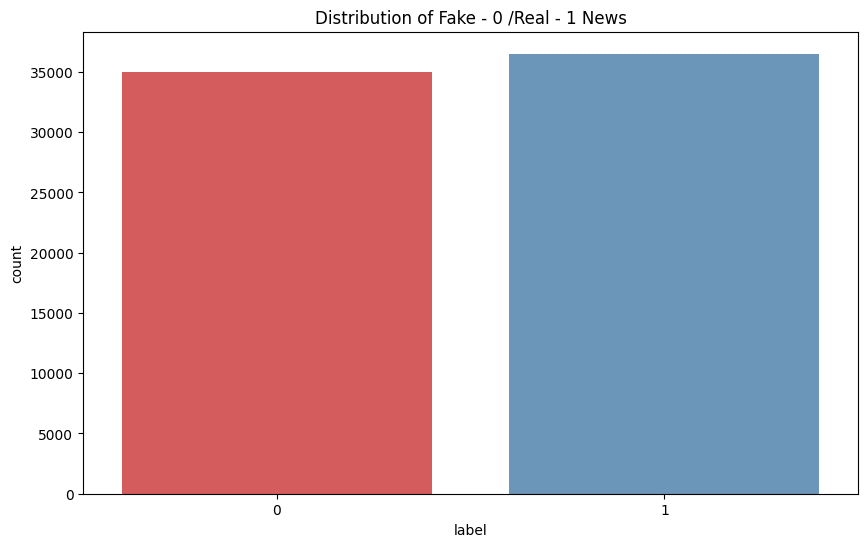

In [70]:
plt.figure(figsize = (10,6))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

/tmp/ipykernel_34/1263977490.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of the News Words count')

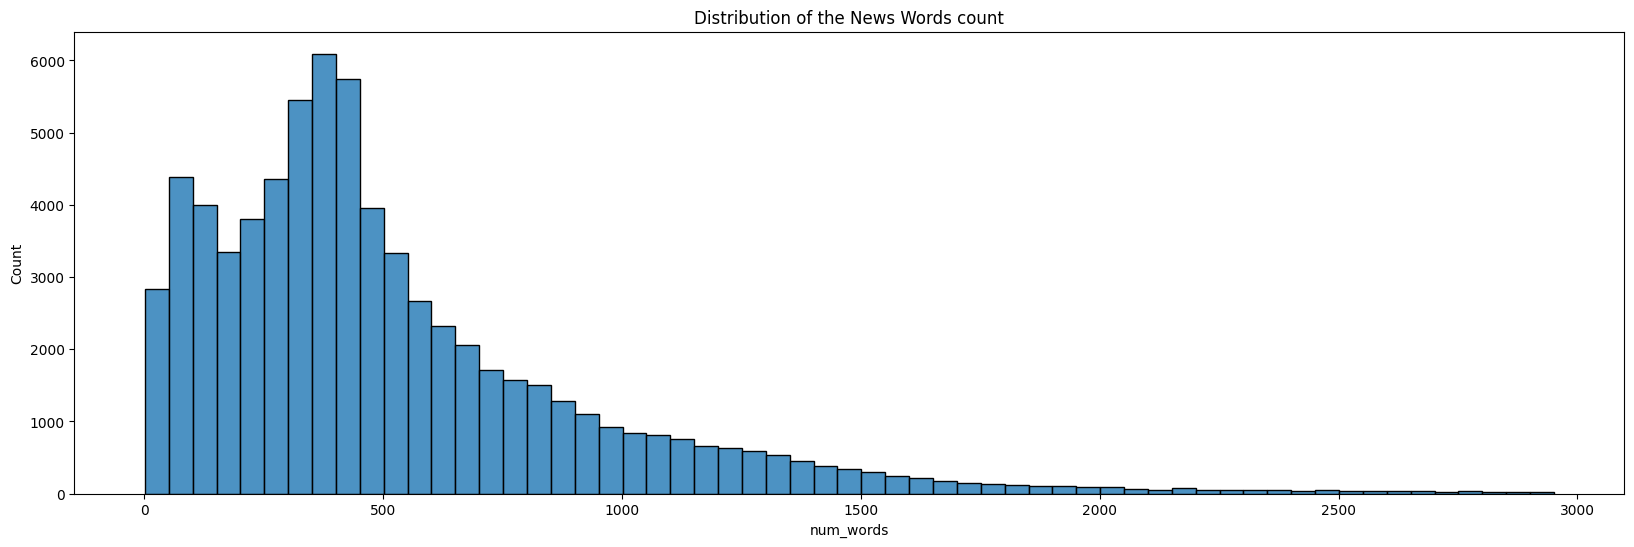

In [71]:
plt.figure(figsize = (20,6))
sns.histplot(df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the News Words count')

In [72]:
#get word collections for real/fake news
#fake_news_words = collections.Counter([word for sentence in df.loc[df['label'] == 0]['text'] for word in sentence.split()])
#real_news_words = collections.Counter([word for sentence in df.loc[df['label'] == 1]['text'] for word in sentence.split()])
# df_mc_fake = pd.DataFrame(columns = ['word','count'], data=(fake_news_words.most_common(20)))
# df_mc_real = pd.DataFrame(columns = ['word','count'], data=(fake_news_words.most_common(20)))

# fig, axes = plt.subplots(1,2,figsize = (15, 6))

# sns.barplot(data = df_mc_fake, x= 'word', y = 'count', color = '#dd0000', alpha = 0.8, ax = axes[0])
# #axes[0].tickparams(axis = 'x', rotation = 90)
# sns.barplot(data = df_mc_real, x= 'word', y = 'count', color = '#0000dd', alpha = 0.8, ax = axes[1])

<a id = 'prepare_input'></a>
## 2. Preparing the input

In [73]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = SEED)

<a id = 'tokenization'></a>
## 2.1 Tokenization 

In [74]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 285418


<a id = 'sequences'></a>
## 2.2 Pad sequences to fixed lenght

In [75]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [76]:
X_train_seq.shape[1]

512

In [77]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    tf.keras.layers.Conv1D(64, 2,activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(.4),
    Dense(2, activation='softmax')
])

#compile model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 512, 128)       │    36,533,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 511, 64)        │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 255, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 255, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,044,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,603,074 (143.44 MB)

 Trainable params: 37,603,074 (143.44 MB)

 Non-trainable params: 0 (0.00 B)

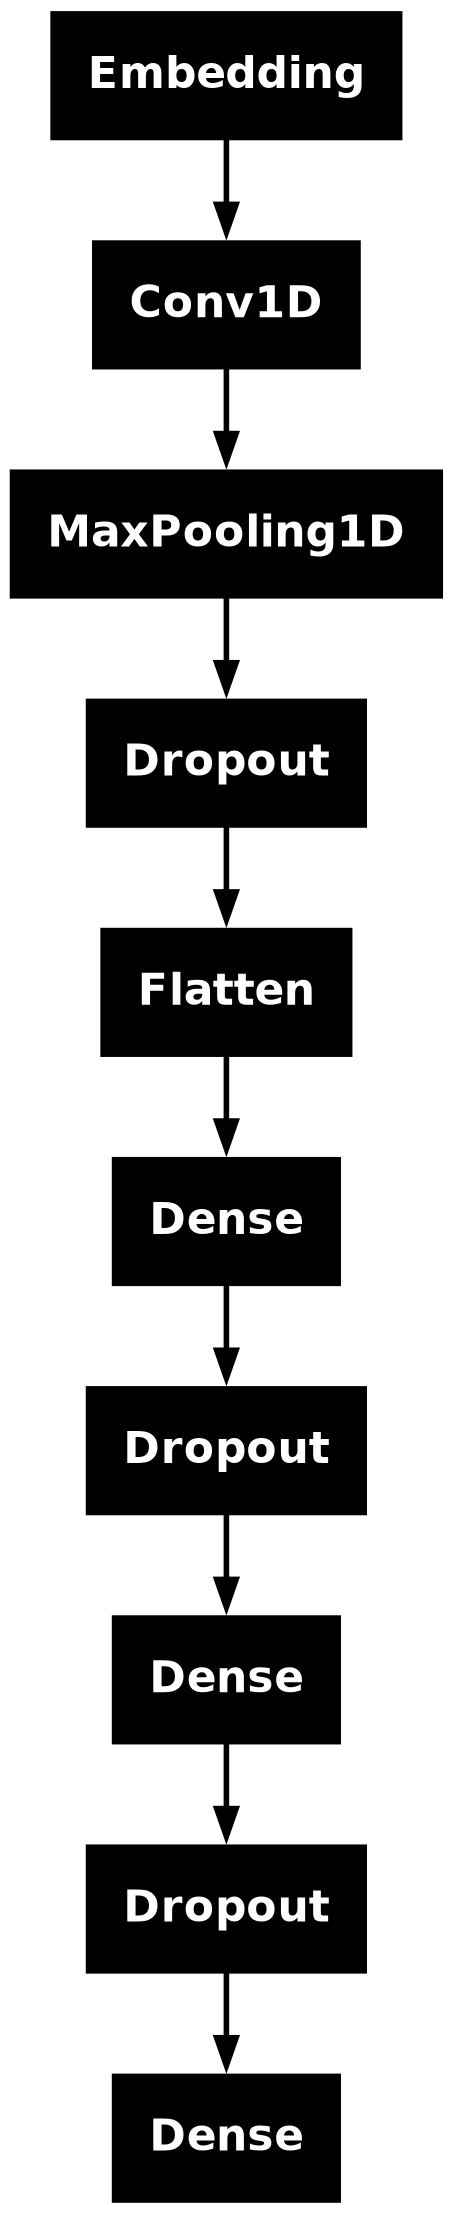

In [78]:
#plot the model architecture
tf.keras.utils.plot_model(model)

<a id = 'train_model'></a>
## 3.2 Training the model

<i><font size = 3.5>We will use a validation split of 20% during the training</font></i>

In [79]:
history = model.fit(X_train_seq, y_train, epochs=30,
                    validation_split = 0.2, batch_size = 500, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/30
 3/86 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5211 - loss: 0.6919 

W0000 00:00:1714770662.435720     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5247 - loss: 0.6913

W0000 00:00:1714770673.685849     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.5248 - loss: 0.6912 - val_accuracy: 0.5648 - val_loss: 0.6767
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6173 - loss: 0.6565 - val_accuracy: 0.8942 - val_loss: 0.3657
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8844 - loss: 0.3244 - val_accuracy: 0.9462 - val_loss: 0.1557
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9442 - loss: 0.1680 - val_accuracy: 0.9591 - val_loss: 0.1105
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9680 - loss: 0.1047 - val_accuracy: 0.9654 - val_loss: 0.0941
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9786 - loss: 0.0709 - val_accuracy: 0.9681 - val_loss: 0.0859
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9873 - loss: 0.0470 - val_accuracy: 0.9697 - val_loss: 0.0852
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9913 - loss: 0.0344 - val_accuracy: 0.9713 - val_loss: 

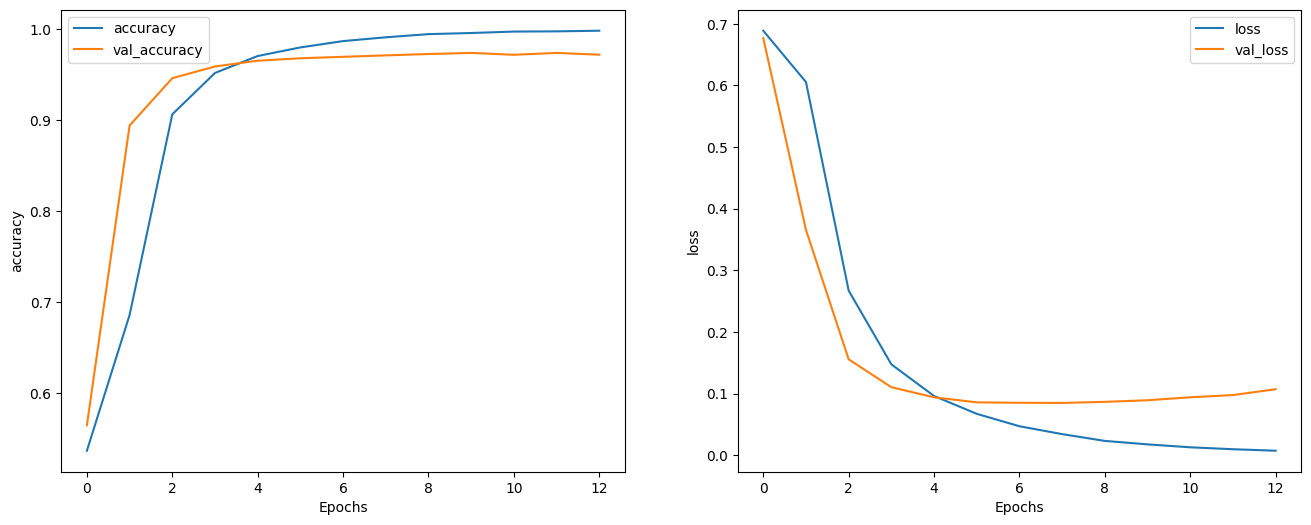

In [80]:
#plot the train/validation loss and accuracy
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

<a id = 'evaluate_model'></a>
## 3.3 Evaluate the model

<i><font size = 3.5>For final evaluation we use the separate test set</font></i>

In [81]:
y_test

62333    1
42035    0
61499    0
59255    1
24317    0
        ..
38315    1
6776     0
27975    0
40576    1
57579    0
Name: label, Length: 17885, dtype: int64

In [82]:
X_test_seq

array([[  655,  5607,     7, ...,    11,   151,   750],
       [    0,     0,     0, ...,   683,   112,   569],
       [    0,     0,     0, ...,     1,   166,    20],
       ...,
       [    0,     0,     0, ...,   514,    43,   151],
       [    0,     0,     0, ...,   514,    43, 39409],
       [22222,     2,  1778, ...,   270,  1154,   957]], dtype=int32)

In [83]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9731 - loss: 0.0900
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Loss: 0.09002458304166794
Test Accuracy: 0.973217785358429


In [84]:
from tensorflow.keras.utils import to_categorical

y_pred_test = model.predict(X_test_seq, batch_size=500)

# For Plot curve
y_pred_evaluation_test = to_categorical(np.argmax(y_pred_test, axis=1), 2)

# For evaluation
y_pred_argmax_test=(np.argmax(y_pred_test, axis=1))

22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

W0000 00:00:1714770731.618781     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [86]:
y_test=np.array(y_test)

In [88]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [89]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [90]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


In [92]:
print("***** Model Evaluations Details ******** \n")
print("******************************")
print("Accurayc  : " , Accuracy(y_test , y_pred_argmax_test)) 
print("******************************")
print("Precision Score is : " , macro_precision(y_test , y_pred_argmax_test))
print("******************************")
print("Recall Scores is : " , macro_recall(y_test , y_pred_argmax_test))
print("******************************")
print('F1 Score is : ', macro_F1Score(y_test , y_pred_argmax_test))
print("******************************")
print('AUC Score is : ' , AUC(y_test , y_pred_argmax_test))

***** Model Evaluations Details ******** 

******************************
Accurayc  :  0.97321778026279
******************************
Precision Score is :  0.9731647929887617
******************************
Recall Scores is :  0.9733373686677301
******************************
F1 Score is :  0.9732122058583389
******************************
AUC Score is :  {0: 0.97333736866773, 1: 0.97333736866773}


Text(70.72222222222221, 0.5, 'Real Labels')

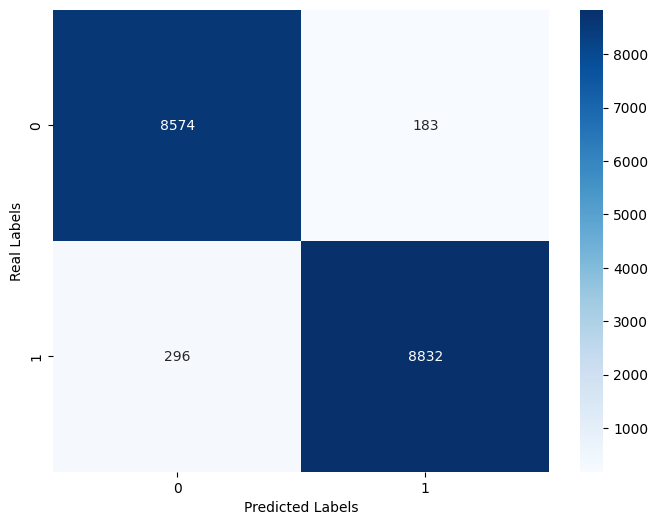

In [93]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test , y_pred_argmax_test), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')